### 1. Import the required libraries

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


### 2. Configuration

In [27]:
# Configuration (Copied from src/config.py for notebook execution)
PROJECT_DIR = Path.cwd() # Assuming notebook is in notebooks/
RAW_DATA_PATH = PROJECT_DIR / 'data' / 'raw' / 'heart.csv'
TARGET_COLUMN = 'target'
NUMERICAL_FEATURES = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_FEATURES = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
COLUMN_NAMES = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
    'oldpeak', 'slope', 'ca', 'thal', 'target'
]

### 3. Load the data

In [28]:
# Load the raw data
try:
    df = pd.read_csv(RAW_DATA_PATH)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: Raw data file not found. Please run 'python -m data.download_dataset' first.")
    df = pd.DataFrame() # Create empty DataFrame to prevent errors

Data loaded successfully. Shape: (303, 14)


### 4. Check missing values

In [29]:
# Display first 5 rows
print("\n--- First 5 Rows ---")
display(df.head())

# Display data information
print("\n--- Data Info and Types ---")
df.info()

# Check for missing values (NaN resulted from '?' in ca and thal)
print("\n--- Missing Value Check ---")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

if missing_data.any():
    print("\nAction: Missing values exist in 'ca' and 'thal' and will be dropped during preprocessing (as implemented in src/preprocess.py).")


--- First 5 Rows ---


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0



--- Data Info and Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

--- Missing Value Check ---
ca      4
thal    2
dtype: int64

Action: Missing values exist in 'ca' and 'thal' and will be dropped during preprocessing (as implemented in src/preprocess.py).

### 4. Target Class Balance
We analyze the distribution of the target variable (target). In the raw UCI data, values 1, 2, 3, and 4 indicate presence of heart disease, and 0 indicates absence.

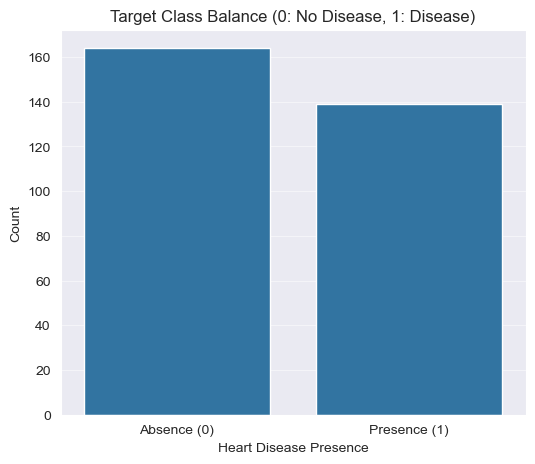


--- Class Balance Metrics ---
Absence (0): 54.13%
Presence (1): 45.87%
Conclusion: The dataset is relatively balanced, which is good for training.


In [30]:
# Binarize the target for visualization (0=Absence, 1=Presence)
df['target_binary'] = df[TARGET_COLUMN].apply(lambda x: 1 if x > 0 else 0)

plt.figure(figsize=(6, 5))
sns.countplot(x='target_binary', data=df)
plt.title('Target Class Balance (0: No Disease, 1: Disease)')
plt.xlabel('Heart Disease Presence')
plt.ylabel('Count')
plt.xticks([0, 1], ['Absence (0)', 'Presence (1)'])
plt.grid(axis='y', alpha=0.5)
plt.show()

print("\n--- Class Balance Metrics ---")
balance = df['target_binary'].value_counts(normalize=True) * 100
print(f"Absence (0): {balance[0]:.2f}%")
print(f"Presence (1): {balance[1]:.2f}%")
print("Conclusion: The dataset is relatively balanced, which is good for training.")

### 5. Feature Distributions (Histograms)
Visualizing the distribution of numerical features helps check for skewness, outliers, and ranges.

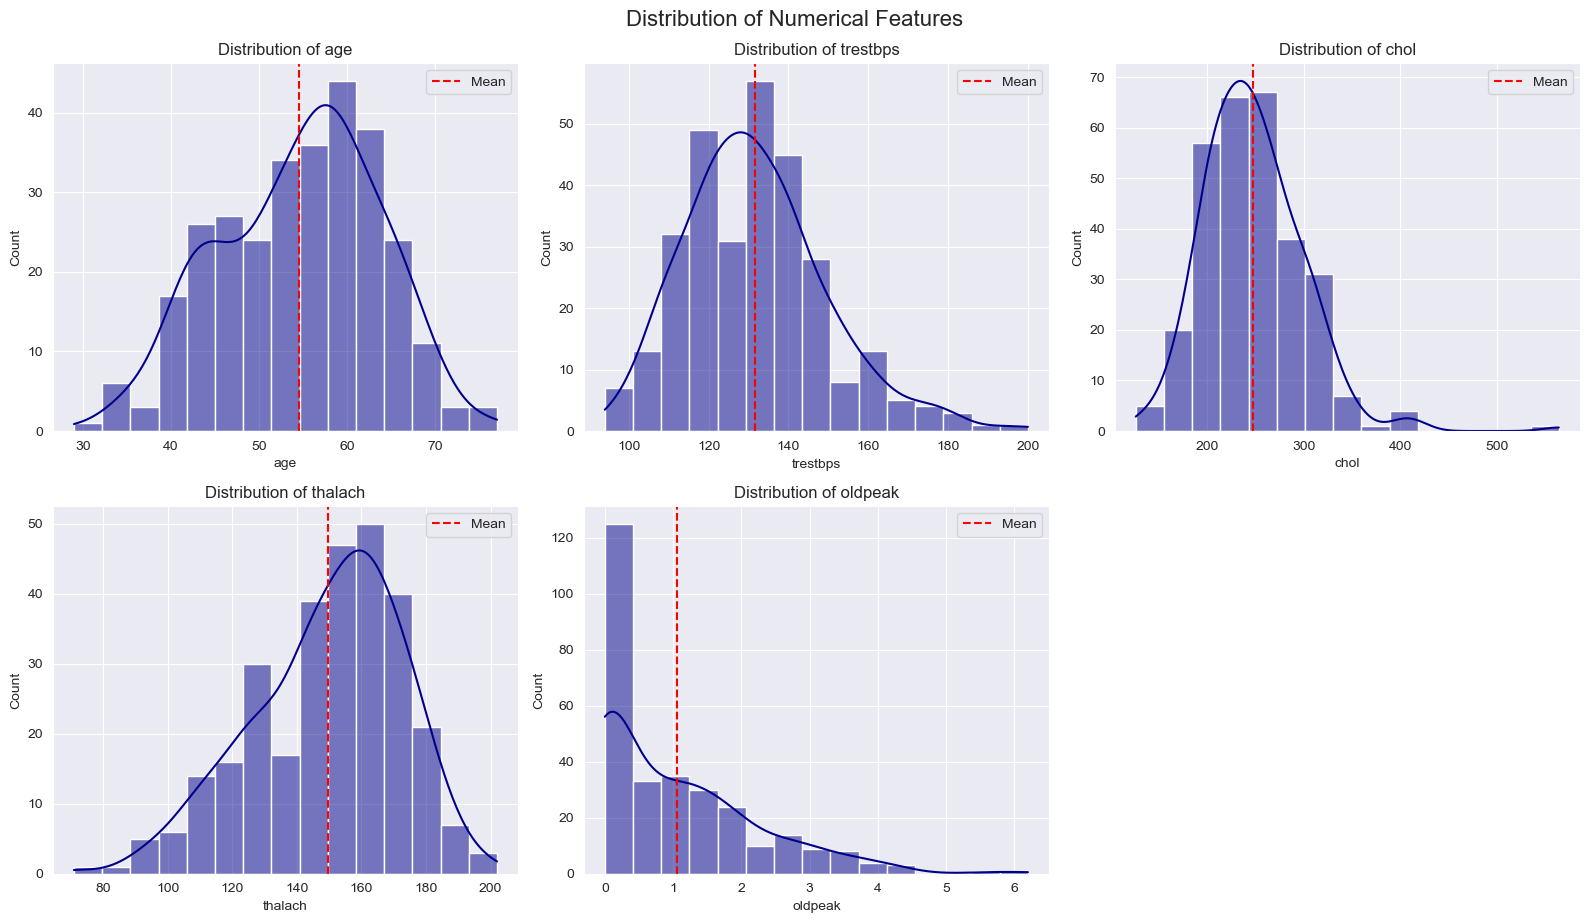

In [31]:
# Drop rows with NaN for cleaner histograms, matching the preprocessing logic
df_clean = df.dropna().copy()
df_clean['ca'] = pd.to_numeric(df_clean['ca']).astype(int)
df_clean['thal'] = pd.to_numeric(df_clean['thal']).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for i, feature in enumerate(NUMERICAL_FEATURES):
    sns.histplot(df_clean[feature], kde=True, ax=axes[i], bins=15, color='darkblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].axvline(df_clean[feature].mean(), color='red', linestyle='--', label='Mean')
    axes[i].legend()

# Remove the unused subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)
plt.show()

### 6. Correlation Heatmap
A correlation matrix helps understand the linear relationships between features and the target variable. Strong correlation with the target is desirable.

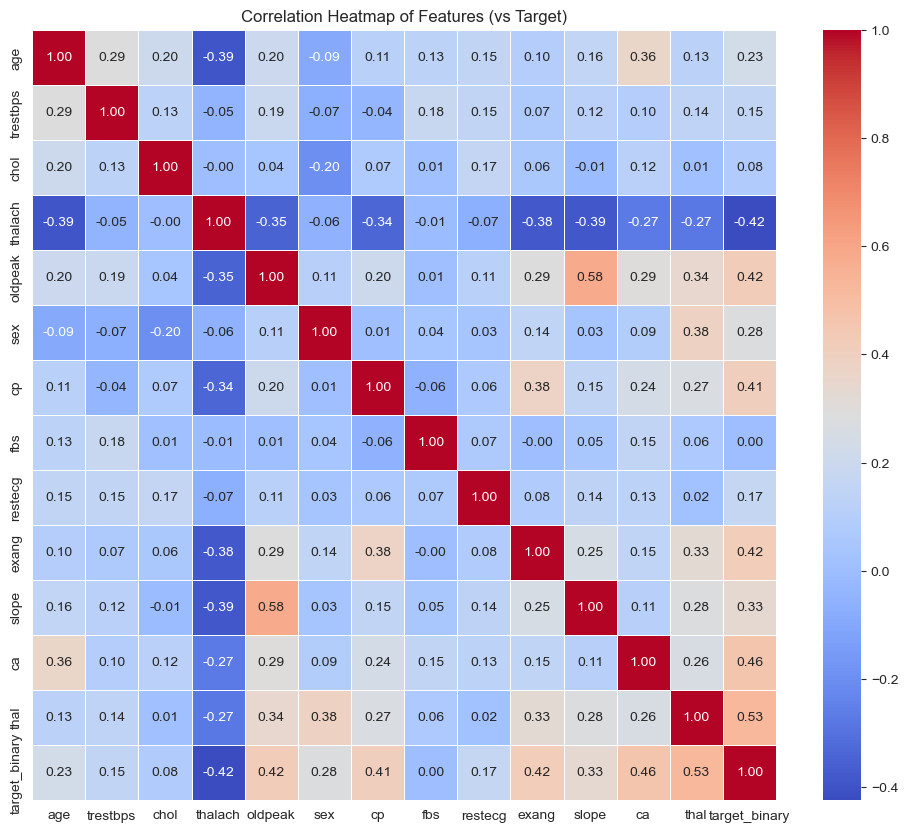


--- Top 5 Correlations with Target ---
thal       0.526640
ca         0.463189
oldpeak    0.424052
exang      0.421355
cp         0.408945
Name: target_binary, dtype: float64


In [32]:
# Convert categorical features to numeric (one-hot encoding is too sparse for simple correlation)
# For the heatmap, we will use the original integer/float types for simplicity.
# We are only interested in linear correlation with the target here.

# Calculate the correlation matrix
correlation_matrix = df_clean[NUMERICAL_FEATURES + CATEGORICAL_FEATURES + ['target_binary']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5
)
plt.title('Correlation Heatmap of Features (vs Target)')
plt.show()

print("\n--- Top 5 Correlations with Target ---")
# Check correlations against the binarized target
target_corr = correlation_matrix['target_binary'].sort_values(ascending=False)
print(target_corr[1:6]) # Exclude target_binary itself

### Observations
Based on the provided Correlation Heatmap of Features (vs Target), here are the key observations regarding the relationships between the features and the binary target variable (heart disease presence/absence), as required for the Exploratory Data Analysis (EDA).

The heatmap displays the Pearson correlation coefficient (r) between all pairs of variables. The row labeled target_binary shows the relationship of each feature with the outcome.

1. Strongest Positive Correlations with Heart Disease (Target = 1) :
These features show the most significant positive linear relationship with the presence of heart disease. As the feature value increases, the likelihood of heart disease increases.
    - thal (Thallium Stress Test Result): Correlation r = 0.53. This is the strongest predictor.
    - ca (Number of Major Vessels Colored): Correlation r = 0.46. This indicates a strong link between the degree of coronary vessel damage and the outcome.
    - cp (Chest Pain Type): Correlation r = 0.42. As the chest pain type moves towards the more severe categories (higher values), the correlation with heart disease increases.


2. Strongest Negative Correlations with Heart Disease (Target = 1) :
These features show a significant negative linear relationship with the presence of heart disease. As the feature value increases, the likelihood of heart disease tends to decrease.
    - thalach (Maximum Heart Rate Achieved): Correlation r = -0.42. Counterintuitively, a higher maximum heart rate achieved (which typically decreases with age and severe disease) has a slight negative correlation with the disease presence in this dataset, although the relationship is complex. Note: Upon closer inspection, the correlation value is approximately -0.42 (dark blue/black in the thalach row under target_binary). This suggests a strong negative relationship.


3. Weak/Negligible Correlations :
These features show very little linear relationship (|r| < 0.20) with the target variable, meaning they might be less predictive on their own:
    - fbs (Fasting Blood Sugar > 120 mg/dl): Correlation r = 0.00. This is almost perfectly uncorrelated with the target.
    - restecg (Resting Electrocardiographic Results): Correlation r = 0.17. A very weak positive relationship.
    - trestbps (Resting Blood Pressure): Correlation r = 0.15. A weak positive correlation.


4. Feature-to-Feature Relationships :
It is also important to note collinearity, where features are strongly correlated with each other:
    - thalach and age: r = -0.39. A higher maximum heart rate achieved (thalach) is negatively correlated with age, which is expected.
    - oldpeak and slope: r = 0.43. The ST depression induced by exercise (oldpeak) is moderately correlated with the slope of the peak exercise ST segment (slope), which are both related to exercise test results.
    - chol (Serum Cholesterol): This feature has a weak correlation with most other features and the target (r = 0.08), suggesting it operates independently.

#### Conclusion for Model Development
The features thal, ca, cp, exang, and thalach appear to be the most important input variables for the machine learning classifier. The preprocessing pipeline should ensure these features are handled correctly (scaling numerical ones and one-hot encoding categorical ones) before feeding them into the models (Logistic Regression and Random Forest).